In [67]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_log_error, make_scorer
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

In [69]:
train_df=pd.read_csv("./playground-series-s5e5/train.csv")
test_df=pd.read_csv("./playground-series-s5e5/test.csv")

In [70]:
train_df['Sex']=train_df['Sex'].apply(lambda x: 1 if x=="male" else 0)
test_df['Sex']=test_df['Sex'].apply(lambda x: 1 if x=="male" else 0)

In [73]:
test_ids=test_df['id']

In [75]:
train_df.drop(columns=['id'], inplace=True)
test_df.drop(columns=['id'], inplace=True)

In [6]:
def detecting_outliers(val):
    sns.boxplot(x=f'{val}', data=train_df)
    plt.title("Box plot")
    plt.show()

In [114]:
def get_iqr_bounds(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

def cap_outliers_with_bounds(df, column, lower_bound, upper_bound):
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

numerical_cols = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
for col in numerical_cols:
    lower, upper = get_iqr_bounds(train_df, col)
    train_df = cap_outliers_with_bounds(train_df, col, lower, upper)
    test_df = cap_outliers_with_bounds(test_df, col, lower, upper)

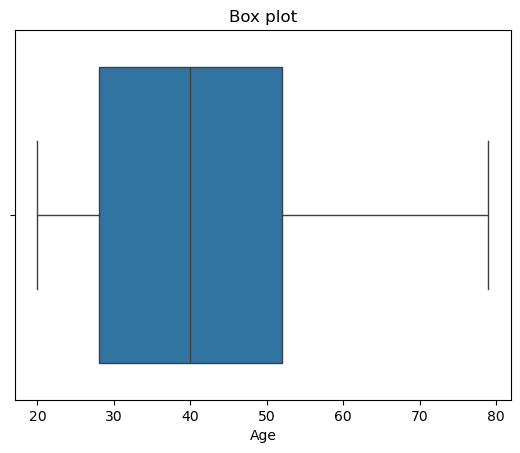

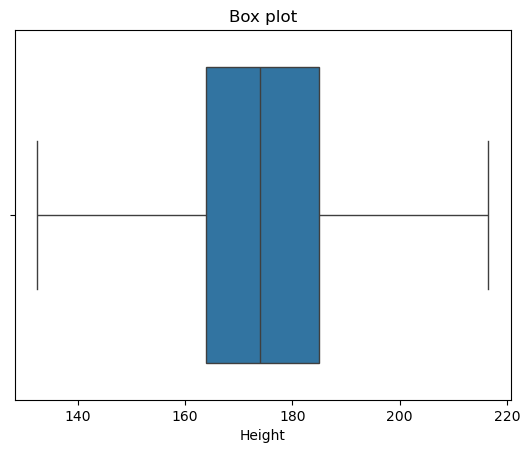

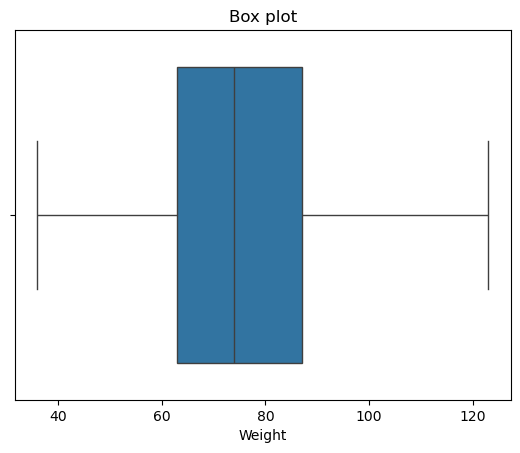

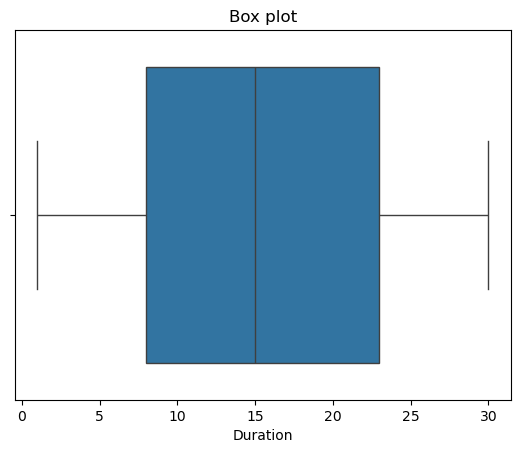

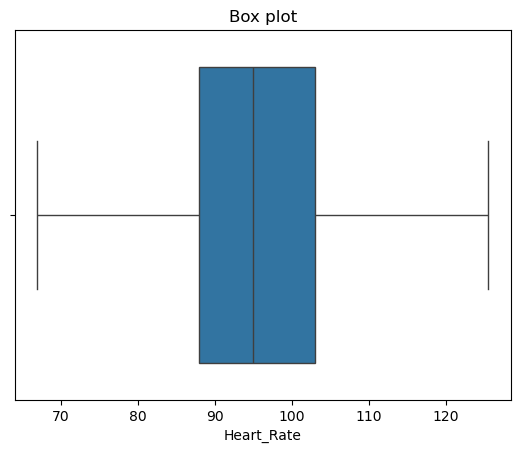

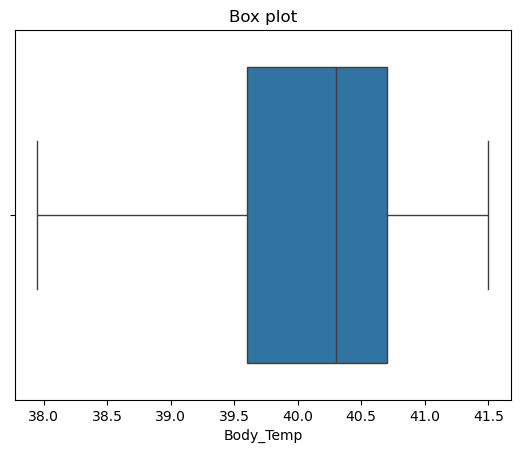

In [116]:
detecting_outliers('Age')
detecting_outliers('Height')
detecting_outliers('Weight')
detecting_outliers('Duration')
detecting_outliers('Heart_Rate')
detecting_outliers('Body_Temp')

In [ ]:
sns.histplot(train_df1['Body_Temp'], bins=10)
plt.show()

In [109]:
train_df1=train_df.copy()
test_df1=test_df.copy()

### Feature Engineering

In [112]:
train_df1.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,1,36,189.0,82.0,26.0,101.0,41.0,150.0
1,0,64,163.0,60.0,8.0,85.0,39.7,34.0
2,0,51,161.0,64.0,7.0,84.0,39.8,29.0
3,1,20,192.0,90.0,25.0,105.0,40.7,140.0
4,0,38,166.0,61.0,25.0,102.0,40.6,146.0


In [775]:
test_df1.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Duration^2,Age_bin,Body_Temp_x_Age_bin_x_Duration
0,1,45,177.0,81.0,7.0,87.0,39.8,49.0,3,835.8
1,1,26,200.0,97.0,20.0,101.0,40.5,400.0,1,810.0
2,0,29,188.0,85.0,16.0,102.0,40.4,256.0,1,646.4
3,0,39,172.0,73.0,20.0,107.0,40.6,400.0,2,1624.0
4,0,30,173.0,67.0,16.0,94.0,40.5,256.0,1,648.0


In [771]:
train_df1['Duration^2']=train_df1['Duration']**2
#train_df1['Body_Temp_Z'] = (train_df1['Body_Temp'] - train_df1['Body_Temp'].mean()) / train_df1['Body_Temp'].std()
train_df1['Age_bin']=pd.cut(train_df1['Age'], bins=[19, 25, 30, 40, 50, 60, 80], labels=False)
train_df1['Body_Temp_x_Age_bin_x_Duration']=train_df1['Body_Temp']*train_df1['Age_bin']*train_df1['Duration']
#train_df1['Heart_Rate^2']=train_df1['Heart_Rate']**2
#train_df1['Heart_Rate_bin']=pd.cut(train_df1['Heart_Rate'], bins=[69, 80, 90, 100, 110, 120], labels=False)
#train_df1['Duration_x_Age_bin']=train_df1['Duration']*train_df1['Age_bin']
#train_df1.drop(columns=['Height'], inplace=True)

test_df1['Duration^2']=test_df1['Duration']**2
#test_df1['Body_Temp_Z'] = (test_df1['Body_Temp'] - test_df1['Body_Temp'].mean()) / test_df1['Body_Temp'].std()
test_df1['Age_bin']=pd.cut(test_df1['Age'], bins=[19, 25, 30, 40, 50, 60, 80], labels=False)
test_df1['Body_Temp_x_Age_bin_x_Duration']=test_df1['Body_Temp']*test_df1['Age_bin']*test_df1['Duration']
#test_df1['Heart_Rate^2']=test_df1['Heart_Rate']**2
#test_df1['Heart_Rate_bin']=pd.cut(test_df1['Heart_Rate'], bins=[69, 75, 90, 100, 110, 120], labels=False)
#test_df1['Duration_x_Age_bin']=test_df1['Duration']*test_df1['Age_bin']
#test_df1.drop(columns=['Height'], inplace=True)

In [777]:
X1=train_df1.drop(columns=['Calories'])
y1=train_df1['Calories']

In [779]:
X1_train, X1_test, y1_train, y1_test=train_test_split(X1, y1, test_size=0.2)

In [781]:
scaler=StandardScaler()

X1_train_scaled=scaler.fit_transform(X1_train)
X1_test_scaled=scaler.transform(X1_test)

test_df1_scaled=scaler.transform(test_df1)

In [783]:
y1_train_log=np.log1p(y1_train)
y1_test_log=np.log1p(y1_test)

In [785]:
lgb_model=lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X1_train_scaled, y1_train_log)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 643
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 10
[LightGBM] [Info] Start training from score 4.141401


LGBMRegressor(random_state=42)

In [737]:
lgb_pred_log=lgb_model.predict(X1_test_scaled)
lgb_pred=np.expm1(lgb_pred_log)

In [739]:
rmsle = np.sqrt(mean_squared_log_error(y1_test, lgb_pred))
print("LightGBM RMSLE:", rmsle)

LightGBM RMSLE: 0.06117552822367304


In [741]:
cat_model=CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X1_train_scaled, y1_train_log)

In [743]:
cat_pred_log=cat_model.predict(X1_test_scaled)
cat_pred=np.expm1(cat_pred_log)

In [745]:
rmsle=np.sqrt(mean_squared_log_error(y1_test, cat_pred))
print("CatBoost RMSLE:", rmsle)

CatBoost RMSLE: 0.05839242356703512


In [747]:
xgb_model=XGBRegressor(verbose=0, random_state=42)
xgb_model.fit(X1_train_scaled, y1_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [749]:
xgb_pred_log=xgb_model.predict(X1_test_scaled)
xgb_pred=np.expm1(xgb_pred_log)

In [751]:
rmsle=np.sqrt(mean_squared_log_error(y1_test, xgb_pred))
print("XGB RMSLE:", rmsle)

XGB RMSLE: 0.06080380278406942


In [753]:
blended_pred_log = 0.1 * lgb_pred_log + 0.8 * cat_pred_log + 0.1 * xgb_pred_log
blended_pred = np.expm1(blended_pred_log)

rmsle = np.sqrt(mean_squared_log_error(y1_test, blended_pred))
print("Blended RMSLE:", rmsle)

Blended RMSLE: 0.05827537605955487


In [757]:
lgb_test_log = lgb_model.predict(test_df1_scaled)
cat_test_log = cat_model.predict(test_df1_scaled)
xgb_test_log = xgb_model.predict(test_df1_scaled)


final_pred_log = 0.1 * lgb_test_log + 0.8 * cat_test_log + 0.1 * xgb_test_log

In [760]:
predictions20=np.expm1(final_pred_log)

In [762]:
submission20=pd.DataFrame({'id': test_ids, 'Calories': predictions20})
submission20.to_csv('submission20.csv', index=False)
print("Submission20 file created")

Submission20 file created


In [521]:
train_df1.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Duration^2,Age_bin
0,1,36,189.0,82.0,26.0,101.0,41.0,150.0,676.0,2
1,0,64,163.0,60.0,8.0,85.0,39.7,34.0,64.0,5
2,0,51,161.0,64.0,7.0,84.0,39.8,29.0,49.0,4
3,1,20,192.0,90.0,25.0,105.0,40.7,140.0,625.0,0
4,0,38,166.0,61.0,25.0,102.0,40.6,146.0,625.0,2


In [339]:
train_df2=train_df.copy()
test_df2=test_df.copy()

In [341]:
train_df2['Duration^2']=train_df2['Duration']**2
train_df2['Age_bin']=pd.cut(train_df2['Age'], bins=[19, 25, 30, 40, 50, 60, 80], labels=False)
#train_df2['Heart_Rate_x_Duration']=train_df2['Heart_Rate']*train_df2['Duration']
train_df2['Age_x_Body_Temp']=train_df2['Age']*train_df2['Body_Temp']
train_df2['Body_Temp_x_Age_bin_x_Duration']=train_df2['Body_Temp']*train_df2['Age_bin']*train_df2['Duration']
#train_df2['Weight_x_Duration']=train_df2['Weight']*train_df2['Duration']
#train_df2.drop(columns='Weight', inplace=True)
#train_df2.drop(columns='Height', inplace=True)

test_df2['Duration^2']=test_df2['Duration']**2
test_df2['Age_bin']=pd.cut(test_df2['Age'], bins=[19, 25, 30, 40, 50, 60, 80], labels=False)
#test_df2['Heart_Rate_x_Duration']=test_df2['Heart_Rate']*test_df2['Duration']
test_df2['Age_x_Body_Temp']=test_df2['Age']*test_df2['Body_Temp']
test_df2['Body_Temp_x_Age_bin_x_Duration']=test_df2['Body_Temp']*test_df2['Age_bin']*test_df2['Duration']
#test_df2['Weight_x_Duration']=test_df2['Weight']*test_df2['Duration']
#test_df2.drop(columns='Weight', inplace=True)
#test_df2.drop(columns='Height', inplace=True)

In [343]:
train_df2.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Duration^2,Age_bin,Age_x_Body_Temp,Body_Temp_x_Age_bin_x_Duration
0,1,36,189.0,82.0,26.0,101.0,41.0,150.0,676.0,2,1476.0,2132.0
1,0,64,163.0,60.0,8.0,85.0,39.7,34.0,64.0,5,2540.8,1588.0
2,0,51,161.0,64.0,7.0,84.0,39.8,29.0,49.0,4,2029.8,1114.4
3,1,20,192.0,90.0,25.0,105.0,40.7,140.0,625.0,0,814.0,0.0
4,0,38,166.0,61.0,25.0,102.0,40.6,146.0,625.0,2,1542.8,2030.0


In [345]:
X2=train_df2.drop(columns=['Calories'])
y2=train_df2['Calories']

In [347]:
X2_train, X2_test, y2_train, y2_test=train_test_split(X2, y2, test_size=0.2)

In [349]:
scaler=StandardScaler()

X2_train_scaled=scaler.fit_transform(X2_train)
X2_test_scaled=scaler.transform(X2_test)

test_df2_scaled=scaler.transform(test_df2)

In [351]:
y2_train_log=np.log1p(y2_train)
y2_test_log=np.log1p(y2_test)

In [353]:
lgb_model=lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X2_train_scaled, y2_train_log)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 900
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 11
[LightGBM] [Info] Start training from score 4.140053


LGBMRegressor(random_state=42)

In [355]:
lgb_pred_log=lgb_model.predict(X2_test_scaled)
lgb_pred=np.expm1(lgb_pred_log)

In [357]:
rmsle = np.sqrt(mean_squared_log_error(y2_test, lgb_pred))
print("LightGBM RMSLE:", rmsle)

LightGBM RMSLE: 0.061390551498753505


In [359]:
cat_model=CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X2_train_scaled, y2_train_log)

In [360]:
cat_pred_log=cat_model.predict(X2_test_scaled)
cat_pred=np.expm1(cat_pred_log)

In [363]:
rmsle=np.sqrt(mean_squared_log_error(y2_test, cat_pred))
print("CatBoost RMSLE:", rmsle)

CatBoost RMSLE: 0.058411062510223405


In [365]:
xgb_model=XGBRegressor(verbose=0, random_state=42)
xgb_model.fit(X2_train_scaled, y2_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [367]:
xgb_pred_log=xgb_model.predict(X2_test_scaled)
xgb_pred=np.expm1(xgb_pred_log)

In [369]:
rmsle=np.sqrt(mean_squared_log_error(y2_test, xgb_pred))
print("XGB RMSLE:", rmsle)

XGB RMSLE: 0.060861758913789886
